# Setup environment

In [1]:
!pip install -q feature_engine verstack

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from feature_engine.creation import CyclicalFeatures
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from verstack import LGBMTuner

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import lightgbm as lgbm
from functools import partial

import optuna
from optuna import Trial

pd.set_option('display.max_columns', None)

## General Helpers

In [4]:
def metric_wrapper(metric, cols=(0, 1, 2)):
    """Hacky-wacky decorator which allows score multioutput predictions with aggregation as a first step"""
    def wrapped(y_true, y_pred):
        y_true = np.sum(np.asarray(y_true)[:, cols], axis=1)
        y_pred = np.sum(np.asarray(y_pred)[:, cols], axis=1)
        return metric(y_true, y_pred)
    
    return wrapped

In [5]:
class WeekSplitter:
    def __init__(self, time_col: pd.Series, skip_first: int = 0):
        self.min_date = time_col.min()
        self.relative_date = time_col - self.min_date
        self.week_number = self.relative_date.dt.days // 7
        self.skip_first = skip_first

    def split(self, X, y=None, groups=None):
        m = self.week_number.max()
        assert self.skip_first < m
        for i in range(self.skip_first, m):
            yield X[self.week_number <= i].index, X[self.week_number == i+1].index

In [6]:
def kfold_loop(X, y, kf, metric_conf, X_test=None, loop_verbose=0, model=None, fit_callbacks=[], *lgbm_args, **lgbm_kwargs):
    if model is None:
        model = lgbm.LGBMClassifier(
            verbose=-1,
            *lgbm_args, **lgbm_kwargs
        )
    oof_pred = []
    scores = {metric: [] for metric in metric_conf}
    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        _X_train = X.loc[train_idx]
        _X_val = X.loc[test_idx]
        _y_train = y.loc[train_idx]
        _y_val = y.loc[test_idx]
        if loop_verbose > 1:
            print(f'--- FOLD {fold+1} ---')
        try: # LGBM-specific
            model.fit(
                _X_train, _y_train,
#                 eval_set=(_X_val, _y_val),
                callbacks=[lgbm.log_evaluation(period=0),
#                            lgbm.early_stopping(3)
                          ] + fit_callbacks,
                categorical_feature='auto'
            )
        except TypeError: # sklearn general
            model.fit(_X_train, _y_train)
        
        
        _y_pred = model.predict(_X_val)
        for metric in metric_conf:
            scores[metric].append(metric_conf[metric](_y_val, _y_pred))

        if loop_verbose > 1:
            for metric in metric_conf: 
                print(f'\t{metric} score: {scores[metric][-1]:.5f}')

        if X_test is not None:
            oof_pred.append(model.predict(X_test))
        else:
            oof_pred.append(model.predict(X))
    if loop_verbose > 0:
        print('\n')
        for metric in metric_conf:
            print(f'fold-mean {metric} score: {np.mean(scores[metric]):.5f}\t fold-std {metric} score: {np.std(scores[metric]):.5f}')
        
    res = {
        'model': model,
        'test_pred': np.array(oof_pred).T,
        'scores': scores,
        'scores_mean': {metric: np.mean(scores[metric]) for metric in metric_conf},
        'scores_std': {metric: np.std(scores[metric]) for metric in metric_conf},
    }
    
    return res

## Config

In [7]:
PATH = "TEST TASK (dataset).zip"

TARGET_COL = ['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30', 'target_full_ltv_day30']
CATEGORY_COL = ['media_source', 'country_code', 'platform']
DATE_COL = ['install_date']

TS_COLS = {
    'sub': ['app_sub_ltv_day0', 'app_sub_ltv_day1', 'app_sub_ltv_day3'],
    'iap': ['app_iap_ltv_day0', 'app_iap_ltv_day1', 'app_iap_ltv_day3'],
    'ad': ['ad_ltv_day0', 'ad_ltv_day1', 'ad_ltv_day3']
}
TS_TARGET = {
    'sub': 'target_sub_ltv_day30',
    'iap': 'target_iap_ltv_day30',
    'ad': 'target_ad_ltv_day30'
}

## Dataloading Helpers

In [32]:
def load_data(path=PATH):
    df = pd.read_csv(path)

    df[CATEGORY_COL] = df[CATEGORY_COL].astype("category")

    for x in DATE_COL:
        df[x] = pd.to_datetime(df[x])

    df = df.sort_values(by="install_date")
    df = df[df['target_sub_ltv_day30'] >= 0]

    targets = df[TARGET_COL]
    features = df[[x for x in df.columns if x not in TARGET_COL]]
    
    return features, targets

## Feature Engineering

In [9]:
def generate_date_features(df):
    df[['install_year', 'install_month', 'install_day']] = df['install_date'].astype(str).str.split('-', expand=True).astype(int)
    
    cyclical = CyclicalFeatures(variables=None, drop_original=True)
    sin_cos_features = cyclical.fit_transform(df[['install_day', 'install_month', 'install_year']])
    df = pd.concat([df, sin_cos_features], axis=1)
    
    df['day_of_week'] = df['install_date'].apply(lambda x: x.weekday())
    
    usb = CustomBusinessDay(calendar = USFederalHolidayCalendar())
    non_holidays = list(pd.date_range('2021-12-01', '2022-01-31', freq=usb))
    df['installed_on_holiday'] = df['install_date'].apply(lambda x: False if x in non_holidays else True)
    
    install_date_users = df['install_date'].value_counts()
    df['users_joined_this_day'] = df['install_date'].apply(lambda x: install_date_users[x])
    
    return df

In [10]:
daily_cols = ['total_sessions_day', 'chapters_finished_day', 'chapters_opened_day', 'chapters_closed_day', 
               'diamonds_received_day', 'diamonds_spent_day', 'tickets_spent_day']
ret_cols  = ['retained_day']
sessions_cols =  ['chapters_finished_session', 'chapters_opened_session',
                          'chapters_closed_session', 'diamonds_spent_session', 'tickets_spent_session']
trg_daily_cols = ['app_sub_ltv_day', 'app_iap_ltv_day', 'app_iap_ltv_day', 'ad_ltv_day']
daily_days, ret_days, sessions_days, trg_daily_days = [0,1,3,7], [1,3,7], [1,3,9], [0,1,3]
    

def count_delta_changes(df):
    def count_difference(cols, days, interval=1):
        for col in cols:
            for i in range(len(days)-1, interval-1, -interval):
                df[col+str(days[i])+'_delta'] = df[col+str(days[i])] - df[col+str(days[i-interval])]
    
    for cols, days in zip([daily_cols, ret_cols, sessions_cols, trg_daily_cols], [daily_days, ret_days, sessions_days, trg_daily_days]):
        count_difference(cols, days)
    
    return df

In [34]:
# for the research purposes lets assume that all the global scope variables are available inside the functions

def process_dataset_baseline(df):
    return df.drop(DATE_COL, axis=1)


def process_dataset_v1(features):
    features = features.copy()
    res = generate_date_features(count_delta_changes(features))
    return res.drop(DATE_COL, axis=1)

# Modeling

## Load & preprocess

In [ ]:
features, targets = load_data(PATH)

X = process_dataset_v1(features)

In [36]:
cv_lr = WeekSplitter(features.install_date)

for ind, col in enumerate(targets.columns[:3]):
    X[f'forecasted_{col}'] = None

for fold, (train_idx, test_idx) in enumerate(cv_lr.split(features, targets)):
    for k in TS_TARGET:
        lr_model = LinearRegression()
        lr_model.fit(features[TS_COLS[k]].loc[train_idx], targets[TS_TARGET[k]].loc[train_idx])
        X.loc[test_idx, f'forecasted_{TS_TARGET[k]}'] = lr_model.predict(features[TS_COLS[k]].loc[test_idx])

for ind, col in enumerate(targets.columns[:3]):
    X[f'forecasted_{col}'].replace({None: 0}, inplace=True)

In [53]:
lr_prod = {
    k: LinearRegression().fit(
        features[TS_COLS[k]],
        targets[TS_TARGET[k]]
    ) for k in TS_TARGET
}

## Tuning

In [25]:
from optuna.integration.lightgbm import LightGBMTuner
import optuna
    

def tune_hyperparams(X, y)
    t = 2 * len(X) // 3

    X_train, X_val, y_train, y_val = (
        X.iloc[:t], X.iloc[t:], y.iloc[:t], y.iloc[t:]
    )
    
    dtrain = lgbm.Dataset(X_train, y_train, categorical_feature=CATEGORY_COL)
    dval = lgbm.Dataset(X_val, y_val, categorical_feature=CATEGORY_COL)

    params = {
    #     'device_type': 'gpu',
        'objective': 'tweedie',
        'metric': 'mae',
        "verbosity": -1,
        "boosting_type": "gbdt",
        'learning_rate': 0.05,
        "seed": 122
    }

    study_tuner = optuna.create_study(direction='minimize')
    optuna.logging.set_verbosity(optuna.logging.WARNING) 

    tuner = LightGBMTuner(
        params, 
        dtrain,
        num_boost_round=1500,
    #     categorical_feature=cat_features,
        valid_sets=[dtrain, dval],
        valid_names=['train', 'val'],
        verbose_eval=False,                            
        early_stopping_rounds=25,
        time_budget=600*3, # 5 hours
        study=study_tuner,
        show_progress_bar=True,
        optuna_seed=42,
    )

    tuner.run()

    print(tuner.best_params)
    print(tuner.best_score) 
    return tuner

In [28]:
opt_res = tune_hyperparams(X, targets[TARGET_COL[3]])


feature_fraction, val_score: 0.098887: 100%|##########| 7/7 [03:14<00:00, 27.84s/it]

num_leaves, val_score: 0.095670: 100%|##########| 20/20 [06:52<00:00, 20.61s/it]

bagging, val_score: 0.095670: 100%|##########| 10/10 [03:29<00:00, 20.97s/it]

feature_fraction_stage2, val_score: 0.095498: 100%|##########| 6/6 [02:09<00:00, 21.52s/it]

regularization_factors, val_score: 0.095355: 100%|##########| 20/20 [07:13<00:00, 21.67s/it]

min_data_in_leaf, val_score: 0.095355: 100%|##########| 5/5 [01:48<00:00, 21.70s/it]

{'objective': 'tweedie', 'metric': 'l1', 'verbosity': -1, 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'seed': 122, 'feature_pre_filter': False, 'lambda_l1': 0.00029938550304646646, 'lambda_l2': 6.320114415891284e-05, 'num_leaves': 256, 'feature_fraction': 0.6479999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
0.09535520477028783


## Train

In [41]:
root_mean_squared_error = partial(mean_squared_error, squared=False)

def mixed_metric(y_true, y_pred, threshold):
    true_zeros_idx = np.where(y_true == 0)
    true_nonzero_idx = np.where(y_true > 0)
    y_pred_cutoff = y_pred.copy()
    y_pred_cutoff[abs(y_pred_cutoff) <= threshold] = 0
    binary_part = (y_true[true_zeros_idx] == 1*(y_pred_cutoff > 0)[true_zeros_idx]).mean()
    return {
        'zero accuracy': binary_part,
        'non-zero rmse': root_mean_squared_error(y_true[true_nonzero_idx], y_pred[true_nonzero_idx]),
        'non-zero mae': mean_absolute_error(y_true[true_nonzero_idx], y_pred[true_nonzero_idx]),
        'non-zero mape': mean_absolute_percentage_error(y_true[true_nonzero_idx], y_pred[true_nonzero_idx])
    }

metrics = {
    "rmse_full": metric_wrapper(root_mean_squared_error, [0, 1, 2]),
    "rmse_sub": metric_wrapper(root_mean_squared_error, [0]),
    "rmse_iap": metric_wrapper(root_mean_squared_error, [1]),
    "rmse_add": metric_wrapper(root_mean_squared_error, [2]),
    "mae_full": metric_wrapper(mean_absolute_error, [0, 1, 2]),
    "mae_sub": metric_wrapper(mean_absolute_error, [0]),
    "mae_iap": metric_wrapper(mean_absolute_error, [1]),
    "mae_add": metric_wrapper(mean_absolute_error, [2])
}

# params = {
#     'use_missing': True,
#     'random_seed': 42,
#     'n_estimators': 100,
#     'learning_rate': 0.1,
#     'verbosity': -1,
#     'objective': 'tweedie'
# }

params = {'objective': 'tweedie',
 'metric': 'l1',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'random_seed': 42,
 'n_estimators': 100,
 'learning_rate': 0.1,
 'feature_pre_filter': False,
 'lambda_l1': 0.00029938550304646646,
 'lambda_l2': 6.320114415891284e-05,
 'num_leaves': 256,
 'feature_fraction': 0.6479999999999999,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

model = MultiOutputRegressor(lgbm.LGBMRegressor(**params))

In [42]:
cv = WeekSplitter(features.install_date, skip_first=1)

res = kfold_loop(X, targets.iloc[:, :3], cv, metrics, loop_verbose=2, model=model)

--- FOLD 1 ---
[LightGBM] [Warning] feature_fraction is set=0.6479999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6479999999999999
[LightGBM] [Warning] lambda_l1 is set=0.00029938550304646646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00029938550304646646
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=6.320114415891284e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.320114415891284e-05
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
	rmse_full score: 1.05046
	rmse_sub score: 0.24387
	rmse_iap score: 0.96707
	rmse_add score: 0.09626
	mae_full score: 0.07168
	mae_sub score: 0.01589
	mae_iap score: 0.05487
	mae_add score: 0.00595
--- FOLD 2 ---
[LightGBM] [Warning] feature_fraction is set=0.6479999999999999, colsample_bytree=1.0 will be ignored. Current v

### Evaluate

In [43]:
pd.DataFrame(res["scores"])

,rmse_full,rmse_sub,rmse_iap,rmse_add,mae_full,mae_sub,mae_iap,mae_add
0,1.050458,0.243868,0.967072,0.096256,0.071685,0.015886,0.054865,0.005954
1,0.991256,0.179055,0.930357,0.067238,0.043206,0.009192,0.033249,0.003861
2,0.743809,0.196820,0.690540,0.055145,0.044743,0.011529,0.034087,0.003598
3,1.141715,0.284633,1.031966,0.127711,0.092151,0.023434,0.068875,0.008384
4,1.199734,0.252006,1.108112,0.142926,0.100108,0.023418,0.075923,0.011002
5,1.384477,0.254395,1.314297,0.117198,0.101235,0.023409,0.076087,0.011283
6,1.075763,0.248244,1.018536,0.073966,0.092970,0.022128,0.071818,0.008645


In [44]:
targets_pred = res['test_pred'].mean(axis=-1).T

In [45]:
for i in [0, 1, 2]:
    print(targets.columns[i], 'non-zero values:', np.round((targets[targets.columns[i]] > 0).mean(), 5))

print('\n')

print('y_true = 0:')
for i in [0, 1, 2]:
    y_true_zero = targets.values[:, i][targets.values[:, i] == 0]
    y_pred_zero = targets_pred[:, i][targets.values[:, i] == 0]
    print(targets.columns[i])
    print('\tRMSE:', np.round(root_mean_squared_error(y_true_zero, y_pred_zero), 5))
    print('\tMAE: ', np.round(mean_absolute_error(y_true_zero, y_pred_zero), 5))    
    
print('\n')
print('y_true > 0:')
for i in [0, 1, 2]:
    y_true_zero = targets.values[:, i][targets.values[:, i] > 0]
    y_pred_zero = targets_pred[:, i][targets.values[:, i] > 0]
    print(targets.columns[i])
    print('\tRMSE:', np.round(root_mean_squared_error(y_true_zero, y_pred_zero), 5))
    print('\tMAE: ', np.round(mean_absolute_error(y_true_zero, y_pred_zero), 5))    
    
print('\n')
print('mixed metric:')
for i in [0, 1, 2]:
    y_true = targets.values[:, i]
    y_pred = targets_pred[:, i]
    print(targets.columns[i])
    temp_metrics = mixed_metric(y_true, y_pred, 0.2)
    for metric in temp_metrics:
        print(f'\t{metric}:', np.round(temp_metrics[metric], 5))

target_sub_ltv_day30 non-zero values: 0.00948
target_iap_ltv_day30 non-zero values: 0.0533
target_ad_ltv_day30 non-zero values: 0.22002


y_true = 0:
target_sub_ltv_day30
	RMSE: 0.0241
	MAE:  0.00075
target_iap_ltv_day30
	RMSE: 0.02692
	MAE:  0.0006
target_ad_ltv_day30
	RMSE: 0.00189
	MAE:  0.0001


y_true > 0:
target_sub_ltv_day30
	RMSE: 1.75181
	MAE:  1.2162
target_iap_ltv_day30
	RMSE: 2.96839
	MAE:  0.72114
target_ad_ltv_day30
	RMSE: 0.14455
	MAE:  0.02324


mixed metric:
target_sub_ltv_day30
	zero accuracy: 0.99966
	non-zero rmse: 1.75181
	non-zero mae: 1.2162
	non-zero mape: 0.8114
target_iap_ltv_day30
	zero accuracy: 0.99954
	non-zero rmse: 2.96839
	non-zero mae: 0.72114
	non-zero mape: 0.14922
target_ad_ltv_day30
	zero accuracy: 0.99999
	non-zero rmse: 0.14455
	non-zero mae: 0.02324
	non-zero mape: 0.20775


## Error Analysis

In [46]:
def residual_test(y_true, y_pred, var_name):
    quantile = 0.98
    res = pd.Series(y_pred - y_true)
    res_quantile = res[abs(res) < res.quantile(quantile)]
    
    fig = plt.figure(figsize=(16, 8), dpi=100)
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[:, 1])
        
    ax1.boxplot(res, vert=False)
    ax1.set_title('Residue = (y_pred - y_true) box plot')
    
    ax2.hist(res_quantile, edgecolor='black', density=True)
    ax2.set_title(f'Histogram of |res| < res.quantile({quantile}) = {res.quantile(quantile):.2f}')
    
    ax3.scatter(y_true, y_pred, s=1)
    max_val = max(y_true.max(), y_pred.max())
    ax3.plot([0, max_val], [0, max_val], c='gray')
    ax3.set_xlabel('true')
    ax3.set_ylabel('pred')
    ax3.set_title(var_name)
    plt.show()

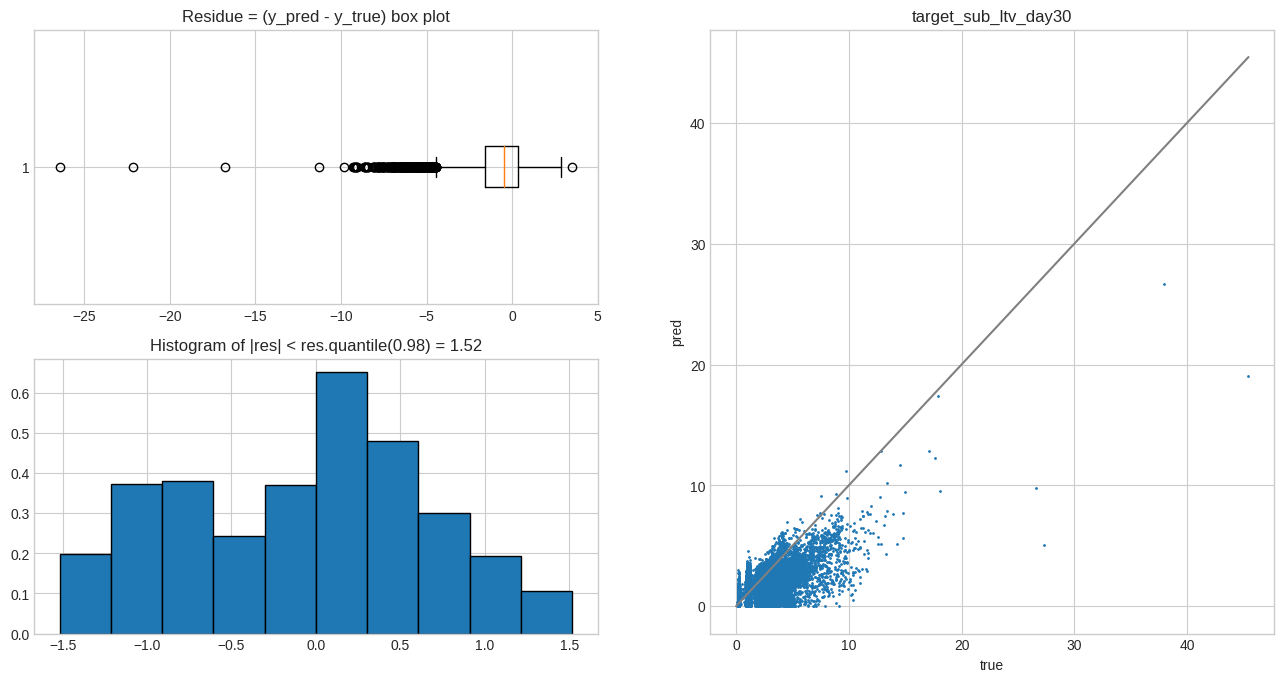

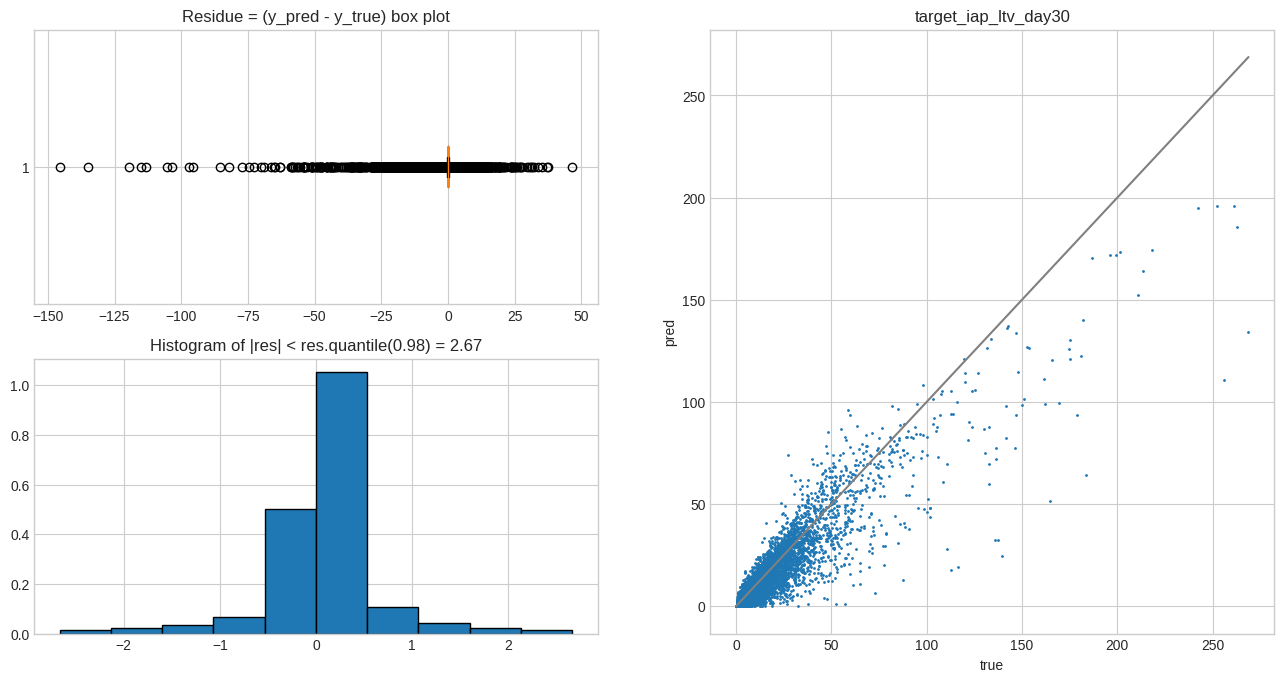

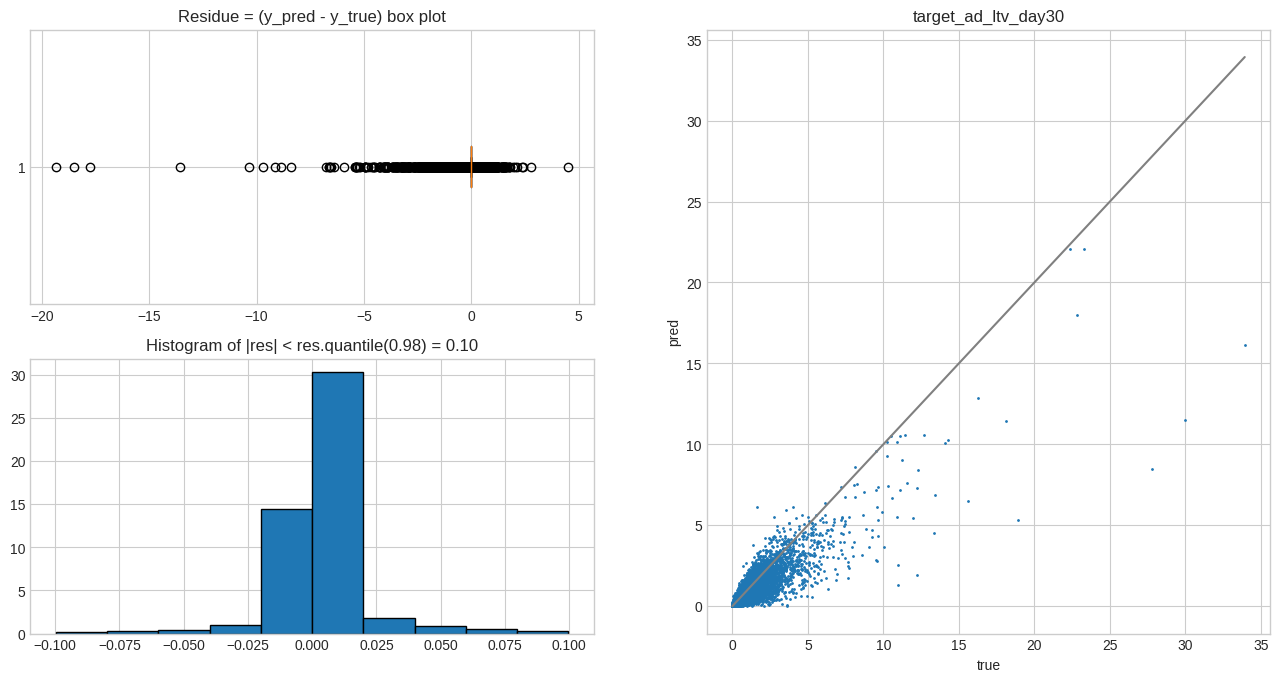

In [47]:
for i in [0, 1, 2]:
    mask = targets.values[:, i] > 0
    residual_test(targets.values[:, i][mask], targets_pred[:, i][mask], targets.columns[i])

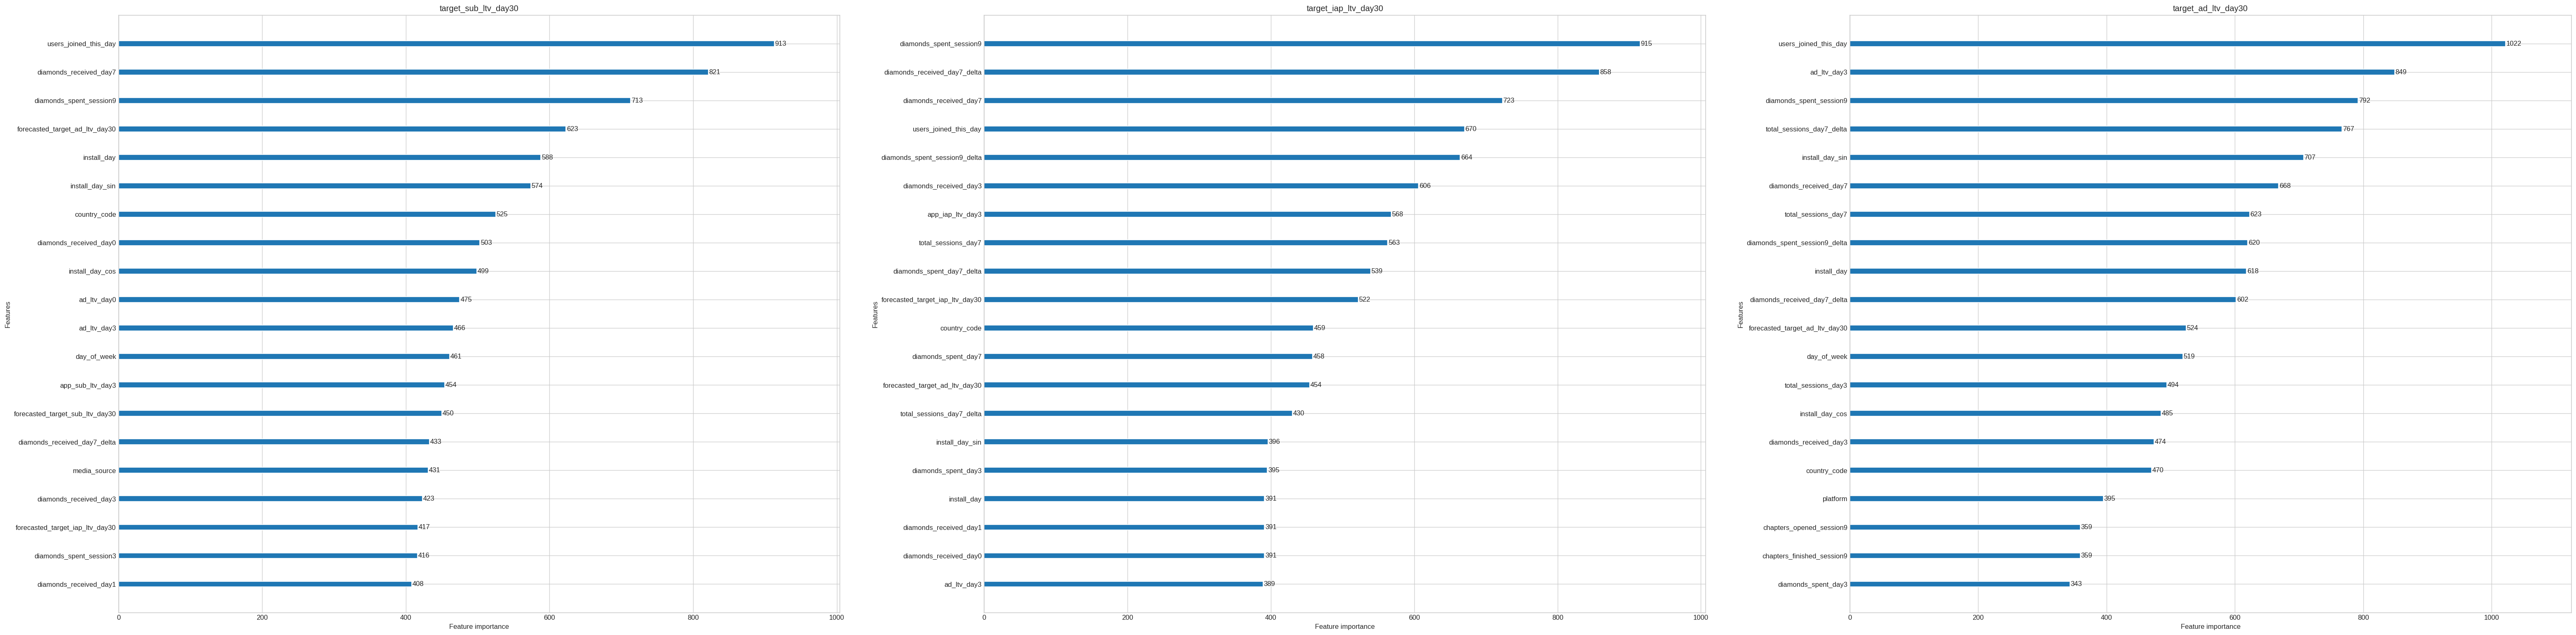

In [48]:
fig = plt.figure(figsize=(64, 16), dpi=120)
gs = fig.add_gridspec(1, 3)
ax = []
for i in range(3):
    ax.append(fig.add_subplot(gs[i]))
    lgbm.plot_importance(res['model'].estimators_[i], figsize=(5, 6), max_num_features=20, ax=ax[i], title=targets.columns[i])
    
plt.savefig('importances.png', bbox_inches='tight')

## Feature importance

In [49]:
importances = pd.concat([pd.DataFrame(
    {'Feature': X.columns, 'Importance': res['model'].estimators_[i].feature_importances_}
).sort_values(by='Importance', ascending=False).reset_index(drop=True) for i in range(3)], axis=1)

importances.columns = pd.MultiIndex.from_arrays([np.repeat(targets.columns[:3], 2), importances.columns.to_list()])

In [50]:
importances.head(20)

target_sub_ltv_day30             \
                            Feature Importance   
0             users_joined_this_day        913   
1            diamonds_received_day7        821   
2           diamonds_spent_session9        713   
3    forecasted_target_ad_ltv_day30        623   
4                       install_day        588   
5                   install_day_sin        574   
6                      country_code        525   
7            diamonds_received_day0        503   
8                   install_day_cos        499   
9                       ad_ltv_day0        475   
10                      ad_ltv_day3        466   
11                      day_of_week        461   
12                 app_sub_ltv_day3        454   
13  forecasted_target_sub_ltv_day30        450   
14     diamonds_received_day7_delta        433   
15                     media_source        431   
16           diamonds_received_day3        423   
17  forecasted_target_iap_ltv_day30        417   
18          diamonds_spent_session3        416   
19           diamonds_received_day1        408   

               target_iap_ltv_day30             \
                            Feature Importance   
0           diamonds_spent_session9        915   
1      diamonds_received_day7_delta        858   
2            diamonds_received_day7        723   
3             users_joined_this_day        670   
4     diamonds_spent_session9_delta        664   
5            diamonds_received_day3        606   
6                  app_iap_ltv_day3        568   
7               total_sessions_day7        563   
8         diamonds_spent_day7_delta        539   
9   forecasted_target_iap_ltv_day30        522   
10                     country_code        459   
11              diamonds_spent_day7        458   
12   forecasted_target_ad_ltv_day30        454   
13        total_sessions_day7_delta        430   
14                  install_day_sin        396   
15              diamonds_spent_day3        395   
16                      install_day        391   
17           diamonds_received_day0        391   
18           diamonds_received_day1        391   
19                      ad_ltv_day3        389   

               target_ad_ltv_day30             
                           Feature Importance  
0            users_joined_this_day       1022  
1                      ad_ltv_day3        849  
2          diamonds_spent_session9        792  
3        total_sessions_day7_delta        767  
4                  install_day_sin        707  
5           diamonds_received_day7        668  
6              total_sessions_day7        623  
7    diamonds_spent_session9_delta        620  
8                      install_day        618  
9     diamonds_received_day7_delta        602  
10  forecasted_target_ad_ltv_day30        524  
11                     day_of_week        519  
12             total_sessions_day3        494  
13                 install_day_cos        485  
14          diamonds_received_day3        474  
15                    country_code        470  
16                        platform        395  
17        chapters_opened_session9        359  
18      chapters_finished_session9        359  
19             diamonds_spent_day3        343

## Save

In [51]:
pred_df = targets.copy()
pred_df[pred_df.columns[:3]] = targets_pred
pred_df['target_full_ltv_day30'] = pred_df[pred_df.columns[:3]].sum(axis=1)

In [52]:
pred_df.to_csv('prediction.csv', index=False)

In [54]:
pd.to_pickle(model, "lgbm_main.pkl.gz")
pd.to_pickle(lr_prod, "lr_prod.pkl.gz")